In [1]:
# A Python implementation of the text2Gregg system
# described in "Writing Gregg Shorthand with METAFONT and LATEX"
# https://www.tug.org/TUGboat/tb29-3/tb93sarman.pdf
# A live demo is available at https://steno.tu-clausthal.de/Gregg.php

# Their system is based on Bezier curves and a 7x7 matrix
# of prototypical CVC (consonant-vowel-consonant) joinings.

In [8]:
!pip install pycairo --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [351]:
import numpy as np
from scipy.integrate import quad

class Bezier:
    def __init__(self, pts):
        """Initialize the control points of the Bezier curve."""
        assert len(pts) == 4, "A cubic Bezier curve requires 4 control points."
        self.pts = np.array(pts)
    
    def __repr__(self):
        return f"Bezier({self.pts})"

    def point(self, t):
        """Calculate the point on the Bezier curve at parameter t."""
        return (1-t)**3 * self.pts[0] + 3*(1-t)**2 * t * self.pts[1] + 3*(1-t) * t**2 * self.pts[2] + t**3 * self.pts[3]

    def derivative(self, t):
        """Calculate the first derivative of the Bezier curve at parameter t."""
        return 3*(1-t)**2 * (self.pts[1] - self.pts[0]) + 6*(1-t) * t * (self.pts[2] - self.pts[1]) + 3*t**2 * (self.pts[3] - self.pts[2])

    def angle(self, t):
        """Calculate the angle of the tangent of the Bezier curve at parameter t."""
        d = self.derivative(t)
        return np.arctan2(d[1], d[0])
    
    def derivative2(self, t):
        """Calculate the second derivative of the Bezier curve at parameter t."""
        return 6*(1-t) * (self.pts[2] - 2*self.pts[1] + self.pts[0]) + 6*t * (self.pts[3] - 2*self.pts[2] + self.pts[1])

    def curvature(self, t):
        """Calculate the curvature of the Bezier curve at parameter t."""
        d1 = self.derivative(t)
        d2 = self.derivative2(t)
        # Add small epsilon to avoid division by zero
        epsilon = 1e-9
        return np.abs(d1[0]*d2[1] - d1[1]*d2[0]) / (np.linalg.norm(d1)**3 + epsilon)

    def length(self, t=1.0):
        """Calculate the length of the Bezier curve up to parameter t using numerical integration."""
        integrand = lambda u: np.linalg.norm(self.derivative(u))
        return quad(integrand, 0, t)[0]  # Use scipy's quad for integration

    def set_origin(self, origin):
        """Translate the Bezier curve so that the first control point is at the origin."""
        shift = self.pts[0] - origin
        self.pts -= shift
        return self

    def scale(self, scalex, scaley=None):
        if scaley is None:
            scaley = scalex
        scale = np.array([scalex, scaley])
        self.pts *= scale
        return self

    def rotate(self, angle):
        """Rotate the Bezier curve by angle (in radians) around the origin."""
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        self.pts = np.dot(self.pts, rot)
        return self


    def plot(self, ax, pretty=False):
        t = np.linspace(0, 1, 200)
        x = [self.point(ti)[0] for ti in t]
        y = [self.point(ti)[1] for ti in t]
        if pretty:
            ax.plot(x, y)
        else:
            ax.plot(x, y)
        if not pretty:
            ax.plot(self.pts[:2,0], self.pts[:2,1], 'go')
            ax.plot(self.pts[2:,0], self.pts[2:,1], 'ro')
        return self

    def show(self):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        self.plot(ax)
        plt.show()
        return self

    def reverse(self):
        """Reverse the direction of the Bezier curve."""
        self.pts = self.pts[::-1]
        return self

    def make_end_zero_curvature(self, scale=1.0):
        """Set the third control point of the Bezier curve (P2) to lie on the line (P1P3)."""
        p1 = self.pts[1]
        p3 = self.pts[3]
        p2 = p1 + scale * (p3 - p1)
        self.pts[2] = p2
        return self

    def copy(self):
        return Bezier(self.pts.copy())

class BezierPath:
    def __init__(self, curves):
        """Initialize a Bezier path from a list of Bezier curves."""
        self.curves = [curve.copy() for curve in curves]

    def __repr__(self):
        return f"BezierPath({self.curves})"
    
    def show(self, pretty=False):
        fig, ax = plt.subplots()
        ax.set_aspect('equal')
        self.plot(ax, pretty=pretty)
        plt.show()
        return self
    
    def plot(self, ax, pretty=False):
        for curve in self.curves:
            curve.plot(ax, pretty=pretty)
        return self

    def continuous_join(self, new_curve):
        new_curve = new_curve.copy()
        end = self.curves[-1].pts[3]
        new_curve.set_origin(end)
        self.curves.append(new_curve)
        return self

    def hard_join_path(self, new_path):
        new_path = new_path.copy()
        end = self.curves[-1].pts[3]
        new_path.set_origin(end)
        self.curves.extend(new_path.curves)
        return self

    def make_g1_continuous(self, scale=1.0):
        # apply tangent continuity to the last two Bezier curves
        c1 = self.curves[-2]
        c2 = self.curves[-1]
        assert np.allclose(c1.pts[3], c2.pts[0]), "Curves are not G0 continuous."
        # we need to set the second control pt of the second curve (Q2) to lie on the line (P3P4)
        q2 = c1.pts[3] + scale * (c1.pts[3] - c1.pts[2])
        c2.pts[1] = q2
        return self

    def scale(self, scalex, scaley=None):
        for curve in self.curves:
            curve.scale(scalex, scaley)
        return self

    def rotate(self, angle):
        for curve in self.curves:
            curve.rotate(angle)
        return self
    
    def reverse(self):
        self.curves = self.curves[::-1]
        for curve in self.curves:
            curve.reverse()
        return self
    
    def set_origin(self, origin):
        shift = self.curves[0].pts[0] - origin
        for curve in self.curves:
            curve.pts -= shift
        return self

    def length(self, t):
        """Calculate the length of the Bezier path up to parameter t."""
        n, t = divmod(t, 1)
        length = 0
        for i, curve in enumerate(self.curves):
            if i < n:
                length += curve.length()
            else:
                length += curve.length(t)
                break
        return length

    def copy(self):
        return BezierPath([curve.copy() for curve in self.curves])


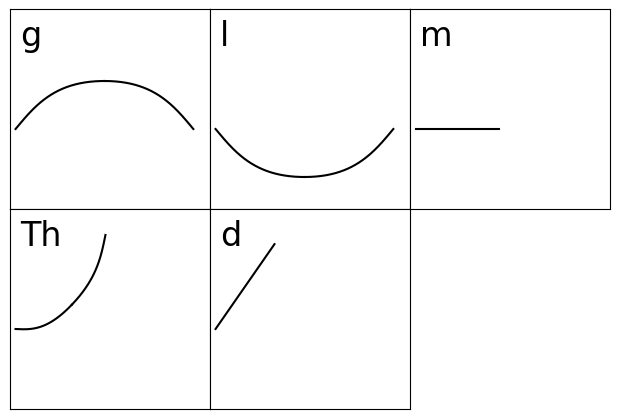

In [276]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

repr_letters = ('g','l','m','Th','d')
repr_letter_curves = {letter: letters[letter] for letter in repr_letters}

n_rows = 2
n_subplots = len(repr_letter_curves)
n_cols = (n_subplots + n_rows - 1) // n_rows  # Ensure enough columns for all subplots

fig = plt.figure(figsize=(2 * n_cols, 2 * n_rows))
gs = gridspec.GridSpec(n_rows, n_cols, wspace=0, hspace=0)  # GridSpec without spacing

for i, (letter, curve) in enumerate(repr_letter_curves.items()):
    ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
    ax.set_xlim(-0.1, 3.5)
    ax.set_ylim(-1, 1.5)
    
    # Don't show ticks or axis labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Plot the curve
    curve.plot(ax, pretty=True)

    # Inset the title inside the plot
    ax.text(0.05, 0.95, letter, transform=ax.transAxes, fontsize=24, verticalalignment='top', 
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    # ax.set_frame_on(False)  # Turn off the frame to avoid padding

# Adjust layout
plt.tight_layout(pad=0)  # Ensure no padding around subplots
plt.show()


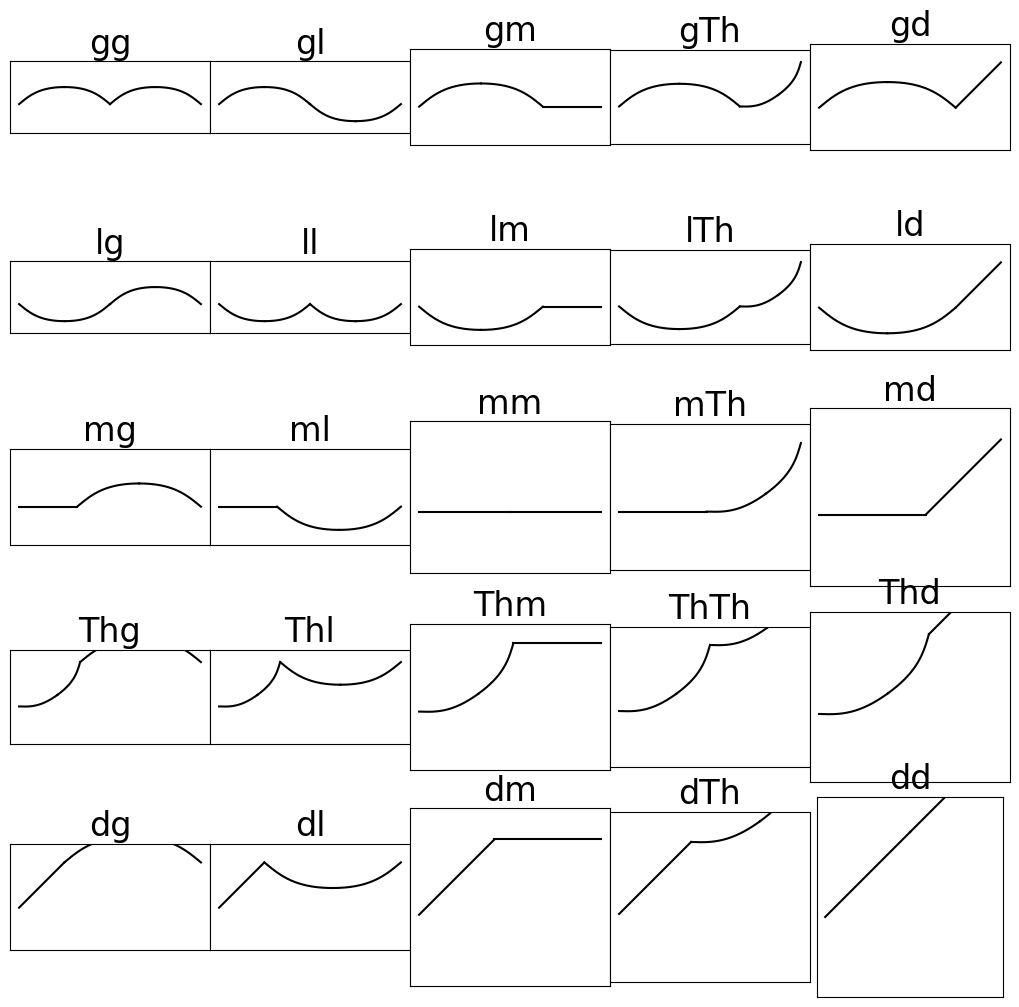

In [278]:
def hard_join_matrix(letters):
    """Join a list of letters using hard joins."""
    joins = []
    for l1 in letters:
        joins.append([])
        for l2 in letters:
            joins[-1].append(letters[l1].copy().hard_join_path(letters[l2].copy()))
    return joins

def show_hard_join_matrix(joins):
    n_rows = len(joins)
    n_cols = len(joins[0])
    fig = plt.figure(figsize=(2 * n_cols, 2 * n_rows))
    gs = gridspec.GridSpec(n_rows, n_cols, wspace=0, hspace=0)  # GridSpec without spacing

    for i, row in enumerate(joins):
        for j, curve in enumerate(row):
            ax = fig.add_subplot(gs[i, j])
            ax.set_ylim(-1, 1.5)
            ax.set_aspect('equal')

            # Don't show ticks or axis labels
            ax.set_xticks([])
            ax.set_yticks([])

            # Plot the curve
            curve.plot(ax, pretty=True)

            # Inset the title inside the plot
            title = f"{repr_letters[i]}{repr_letters[j]}"
            # ax.text(0.05, 0.95, title, fontsize=24, verticalalignment='top', 
                    # bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
            ax.set_title(title, fontsize=24)

    # Adjust layout
    plt.tight_layout(pad=0)  # Ensure no padding around subplots
    plt.show()

joins = hard_join_matrix(repr_letter_curves) 
show_hard_join_matrix(joins)

## Calculation of control points from curvature
We use the following notation for the tangents and curvature

\begin{align}
d_1, d_2 & \hspace{0.4in} \text{unit tangents} \\
\delta_1, \delta_2 & \hspace{0.4in} \text{tangent magnitudes} \\
\kappa_1, \kappa_2 & \hspace{0.4in} \text{curvature}
\end{align}

We can write the control points in terms of the tangents as
\begin{align}
z_0^+ &= z_0 + \delta_0d_0 \\
z_1^- &= z_1 - \delta_1d_1
\end{align}

We can relate the tangents to the curvature. (See equations 1-2 from the paper.)
\begin{align}
(d_0 \times d_1)\delta_0 &= (a \times d_1) - \frac{3}{2}\kappa_1\delta_1^2 \\[0.2in]
(d_0 \times d_1)\delta_1 &= (d_0 \times a) - \frac{3}{2}\kappa_0\delta_0^2 \\[0.2in]
\text{where }\hspace{0.6in} a &= z_1 - z_0
\end{align}


A Bezier curve has eight degrees of freedom. Specifying the endpoints and unit tangents takes six degrees of freedom. This allows us two degrees of freedom to specify the curvatures or equivalently the tangent magnitudes. In other words, how long are the two handles?

In [314]:
(4/3)*np.tan(np.pi/8)

np.float64(0.5522847498307933)

In [320]:
import numpy as np
from scipy.optimize import fsolve

def solve_delta_kappa(d0, d1, a, kappa0, kappa1):
    # d0, d1, a are 2D vectors (numpy arrays), kappa0 and kappa1 are known scalars

    def cross(a, b):
        return a[0]*b[1] - a[1]*b[0]
    
    def equations(vars):
        delta0, delta1 = vars
        cross_d0_d1 = cross(d0, d1)  # Scalar value from 2D cross product
        cross_a_d1 = cross(a, d1)
        cross_d0_a = cross(d0, a)
        
        eq1 = cross_d0_d1 * delta0 - (cross_a_d1 - (3/2) * kappa1 * delta1**2)
        eq2 = cross_d0_d1 * delta1 - (cross_d0_a - (3/2) * kappa0 * delta0**2)
        
        return [eq1, eq2]
    
    # Initial guesses for delta0 and delta1 (can tweak these if necessary)
    initial_guess = [1.0, 1.0]
    
    # Use fsolve to solve the system of equations
    solution = fsolve(equations, initial_guess, xtol=1e-9)
    
    delta0, delta1 = solution
    return delta0, delta1

solve_delta_kappa(np.array([0, 1]), np.array([-1, 0]), np.array([-1, 1]), 1, 1)

(np.float64(0.5485837703548635), np.float64(0.5485837703548635))

## Setting $\kappa_0=0$ at the beginning of the circle
We follow the authors in creating a flat-headed circle with zero curvature at its end.
This allows for G2 continuous joins.
But I really doubt the difference is visually perceptible.

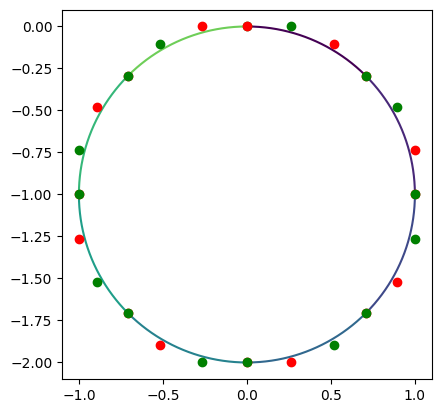

BezierPath([Bezier([[ 0.          0.        ]
 [ 0.26521649  0.        ]
 [ 0.5195704  -0.10535684]
 [ 0.70710678 -0.29289322]]), Bezier([[ 0.70710678 -0.29289322]
 [ 0.89464316 -0.4804296 ]
 [ 1.         -0.73478351]
 [ 1.         -1.        ]]), Bezier([[ 1.         -1.        ]
 [ 1.         -1.26521649]
 [ 0.89464316 -1.5195704 ]
 [ 0.70710678 -1.70710678]]), Bezier([[ 7.07106781e-01 -1.70710678e+00]
 [ 5.19570403e-01 -1.89464316e+00]
 [ 2.65216490e-01 -2.00000000e+00]
 [ 4.67691728e-17 -2.00000000e+00]]), Bezier([[ 4.67691728e-17 -2.00000000e+00]
 [-2.65216490e-01 -2.00000000e+00]
 [-5.19570403e-01 -1.89464316e+00]
 [-7.07106781e-01 -1.70710678e+00]]), Bezier([[-0.70710678 -1.70710678]
 [-0.89464316 -1.5195704 ]
 [-1.         -1.26521649]
 [-1.         -1.        ]]), Bezier([[-1.         -1.        ]
 [-1.         -0.73478351]
 [-0.89464316 -0.4804296 ]
 [-0.70710678 -0.29289322]]), Bezier([[-7.07106781e-01 -2.92893219e-01]
 [-5.19570403e-01 -1.05356840e-01]
 [-2.65216490e-01 -1.

In [365]:
def quarter_circle_bezier():
    """Return a Bezier curve for a quarter circle."""
    k = 0.5522847498  # Kappa constant for a cubic Bezier curve
    return Bezier([[1, 0], [1, k], [k, 1], [0, 1]])

def eigth_circle_bezier():
    k = (4 / 3) * np.tan(np.pi / 16) 
    # the traditional segment approximation of a circle is δ_i=(4/3)tan(theta/4) κ_i=-(1-sin^4(theta/4))
    p0 = np.array([1, 0])
    p1 = np.array([1, k])
    p3 = np.array([np.cos(np.pi / 4), np.sin(np.pi / 4)])
    tan2 = np.array([np.cos(np.pi / 4), -np.sin(np.pi / 4)])
    p2 = p3 + k * tan2
    curve = Bezier([p0, p1, p2, p3])
    return curve

def flat_eigth_circle_bezier():
    # create a segment with zero curvature
    z0 = np.array([1, 0])
    theta = np.pi / 4
    z1 = np.array([np.cos(theta), np.sin(theta)])
    a = z1 - z0
    d0 = np.array([0, 1])
    d1 = np.array([-np.sin(theta), np.cos(theta)])
    kappa_0 = 0
    kappa_1 = 1
    delta_1, delta_2 = solve_delta_kappa(d0, d1, a, kappa_0, kappa_1)
    z0_plus = z0 + delta_1 * d0
    z1_minus = z1 - delta_2 * d1
    return Bezier([z0, z0_plus, z1_minus, z1])

# plot flat eigth circle against eigth circle
# fig, ax = plt.subplots()
# ax.set_aspect('equal')
# seg = eigth_circle_bezier()
# seg.plot(ax)
# flat_seg = flat_eigth_circle_bezier()
# flat_seg.plot(ax)
# plt.show()

# eigth_circle_bezier().show()

def full_circle_bezier_path():
    curves = []
    for k in range(8):
        curve = eigth_circle_bezier().reverse().rotate(k * np.pi / 4)
        curves.append(curve)
    path = BezierPath(curves)
    path.rotate(np.pi / 4).rotate(- np.pi / 2).set_origin([0, 0])
    return path

full_circle_bezier_path().show()

In [349]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def apply_gradual_color_cycle(num_colors=10, cmap_name='viridis'):
    """
    Apply a gradual color cycle with a specified number of colors and colormap.

    Parameters:
    num_colors (int): Number of colors in the cycle. Default is 100.
    cmap_name (str): Name of the Matplotlib colormap to use. Default is 'viridis'.
    """
    # Get the colormap with the specified number of colors
    cmap = cm.get_cmap(cmap_name, num_colors)

    # Generate a list of colors from the colormap
    colors = [cmap(i) for i in range(num_colors)]

    # Set the color cycle for all future plots
    plt.rc('axes', prop_cycle=plt.cycler('color', colors))

# Example usage
apply_gradual_color_cycle()  # Applies a cycle of 100 'viridis' colors by default


/tmp/ipykernel_251603/2613619585.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name, num_colors)


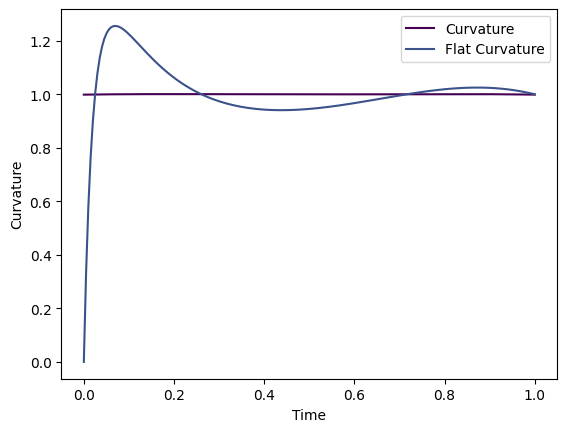

In [345]:
# plot curvature versus time
ts = np.linspace(0, 1, 200)
curvatures = [eigth_circle_bezier().curvature(t) for t in ts]
curvatures_flat = [flat_eigth_circle_bezier().curvature(t) for t in ts]
plt.plot(ts, curvatures, label='Curvature')
plt.plot(ts, curvatures_flat, label='Flat Curvature')
plt.xlabel('Time')
plt.ylabel('Curvature')
plt.legend()
